# Wasserstein GAN в задаче идентификации аномалий в геофизических данных
<br /><br />
Применение WGAN для идентификации аномалий в данных, описывающих состояние стратосферы на уровне 10гПа в северном полушарии.
<br /><br />
Известно, что обычно состояние стратосферы над северным полушарием в зимний период описывается как стратосферный полярный вихрь (СПВ). Это вихрь, образующийся под действием силы Кориолиса при условии выхолаживания полярной области стратосферы и, как следствие, возникновения градиента давления между полярной областью и умеренными широтами.

### Исходные данные
В этом исследовании состояние стратосферы будет описываться полями потенциальной завихренности (переменная `pv`) и высоты геопотенциала (переменная `gh`) на уровне 10гПа. Эти данные ограничены по широте: в исходных файлах представлены значения севернее $40^\circ$N, спроецированные с использованием полярной проекции. Кроме того, исходные данные уже отнормированы к интервалу $[0,1]$.
<br /><br />
Исходные данные исследования можно скачать по следующим ссылкам: [pv data](https://www.dropbox.com/s/ohwfyrmj4zl94q9/pv_data_projected_all.normed01.npy?dl=0); [gh data](https://www.dropbox.com/s/v3qjgzsls6et6cw/hgt_data_projected_all.normed01.npy?dl=0)
<br />
Маску для исключения несущественных зон снимка из рассмотрения можно скачать по ссылке: [mask data](https://www.dropbox.com/s/7s6lgdi01f8plkz/mask_256.npy?dl=0)

### Внезапные стратосферные потепления как аномалии
Примерно с частотой один раз в 1.6 лет состояние стратосферы кардинально меняется, и сильный устойчивый вихрь, видный на диаграмме выше, распадается совсем или как минимум сильно возмущается и смещается с полюса. Эти состояния редки, и именно поэтому в этом исследовании будем считать их аномалиями. Цель исследования - применить набор нейросетевых моделей для поиска таких аномалий.

# Порождающие состязательные сети
Порождающие состязательные сети (ПСС, Generative Adversarial Networks, GAN) - нейросетевые модели, отличающиеся от обычных дискриминативных моделей в смысле методики обучения и сэмплирования данных.

Терминология в GAN включает "реальные объекты" (real objects) - такие, которые порождены реальным процессом и даны в форме обучающей выборки, и "фейковые" или "порожденные" объекты (fake objects) - такие, которые являются результатом вычисления генератора $\mathcal{G}(\mathbb{\cdot})$ на входных данных $z$. При этом входные данные $z$ - это шум, порожденный из специального распределения. Обычно берут многомерное стандартное нормальное распределение. Порождаемые векторы шума (noise) также называют векторами скрытого представления (hidden representations или embeddings) по аналогии с терминологией автокодировщиков. В этом смысле генератор GAN - аналог декодера.

При этом дискриминатор $\mathcal{D}(\mathbb{\cdot})$ - подсеть, задача которой различать реальные и фейковые объекты, базируясь на их признаковом представлении. В определенном смысле дискриминатор - всего лишь нейросеть, решающая задачу бинарной классификации между реальными и фейковыми объектами.

Принцип обучения GAN состоит в том, что две подсети (генератор и дискриминатор) должны решать две противоположные задачи: генератор должен порождать примеры, настолько похожие на реальные, чтобы дискриминатор не мог их различить; при этом дискриминатор должен учиться все равно различать эти примеры.

Обозначения, которые вводятся для GAN:
- $z$ - шумовой вектор (noise) в пространстве скрытых представлений $\mathbb{Z}$;
- $x$ - признаковое описание реального объекта (!!! именно в пространстве признаков $\mathbb{X}$ !!!);
- $\mathcal{G}(z)$ - генератор, нейросеть, порождающая "фейковые" объекты из векторов $z$. Генератор переводит векторы пространства $\mathbb{Z}$ в векторы пространства $\mathbb{X}$:
$$
\mathcal{G}(\mathbf{\cdot}): \mathbb{Z}\to\mathbb{X}
$$
- $\mathcal{D}(x)$ - дискриминатор, нейросеть, решающая задачу классификации векторов пространства $\mathbb{X}$ на "реальные" и "фейковые".

В дальнейшем был предложен усовершенствованный алгоритм обучения WGAN с наложением ограничений на градиент дискриминатора $\mathcal{D}(x)$ по входным данным $x$ - Wasserstein GAN with Gradient Penalty ([WGAN-GP](https://arxiv.org/abs/1704.00028))
<br /><br />

#### Применение WGAN-GP для порождения сбалансированной выборки "обычных" и "аномальных" объектов

В качестве альтернативного решения такой задачи в этом задании (во второй части) предлагается создать нейросетевой классификатор $\mathcal{F}(x)$, способный разделять объекты $x$ на обычные, характерные для выборки, и аномальные. Вопрос в том, - как его обучить?

В случае, когда в нашем распоряжении есть генератор $\mathcal{G}(z)$, обученный порождать как "обычные" объекты, так и "аномальные", можно сгенерировать достаточное количество обучающих примеров для такого бинарного классификатора $\mathcal{F}(x)$. При этом метка $y_i$ "обычный"/"аномальный" будет доступна по условию порождения таких примеров: в силах исследователя в момент генерации шумового вектора $z_i$ классифицировать его, руководствуясь его нормой:

- Если $|z_i|_2>q_{0.98}(|z|_2)$, то объект может считаться аномальным, $y_i=1$
- Иначе объект может считаться обычным, $y_i=0$

Отметим также, что в силах исследователя регулировать порождение сбалансированной выборки, что важно для обучения надежного классификатора. Для этого на этапе порождения векторов $z$ следует следить за сбалансированностью их с точки зрения классификации на "обычные" и "аномальные".

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torchvision
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
#from libs.service_defs import * ### no module
import torch.autograd as autograd
from scipy import stats
from torch.utils.tensorboard import SummaryWriter

from typing import Tuple, List, Type, Dict, Any

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Проверим доступность GPU
torch.cuda.device_count()

1

In [5]:
Tensor = torch.FloatTensor #torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [6]:
class DS(Dataset):
    def __init__(self,
                 pv_fname: str = '',
                 gh_fname: str = '',
                 mask_fname: str = '',
                 transform: Any = None):

        self.pv_data = np.load(pv_fname, mmap_mode='r')
        self.gh_data = np.load(gh_fname, mmap_mode='r')
        self.mask = np.load(mask_fname, mmap_mode='r')
        self.transforms = transform
        

    def __getitem__(self, index):
        x = np.zeros((2,256,256))
        
        x[0] = ma.masked_array(self.pv_data[index], mask=self.mask) 
        x[1] = ma.masked_array(self.gh_data[index], mask=self.mask) 
        if self.transforms is not None:
            x = self.transforms(x)
        return x
    

    def __len__(self):
        length = 0
        length = self.pv_data.shape[0]

        return length

In [7]:
train_transforms = lambda x: Tensor(x)

In [8]:
train_dataset = DS('/content/gdrive/MyDrive/wgan_data/pv_data_projected_all.normed01.npy',
                   '/content/gdrive/MyDrive/wgan_data/hgt_data_projected_all.normed01.npy',
                   '/content/gdrive/MyDrive/wgan_data/mask_256.npy',
                   train_transforms)

Для контроля можно отобразить порождаемые этим классом объекты:

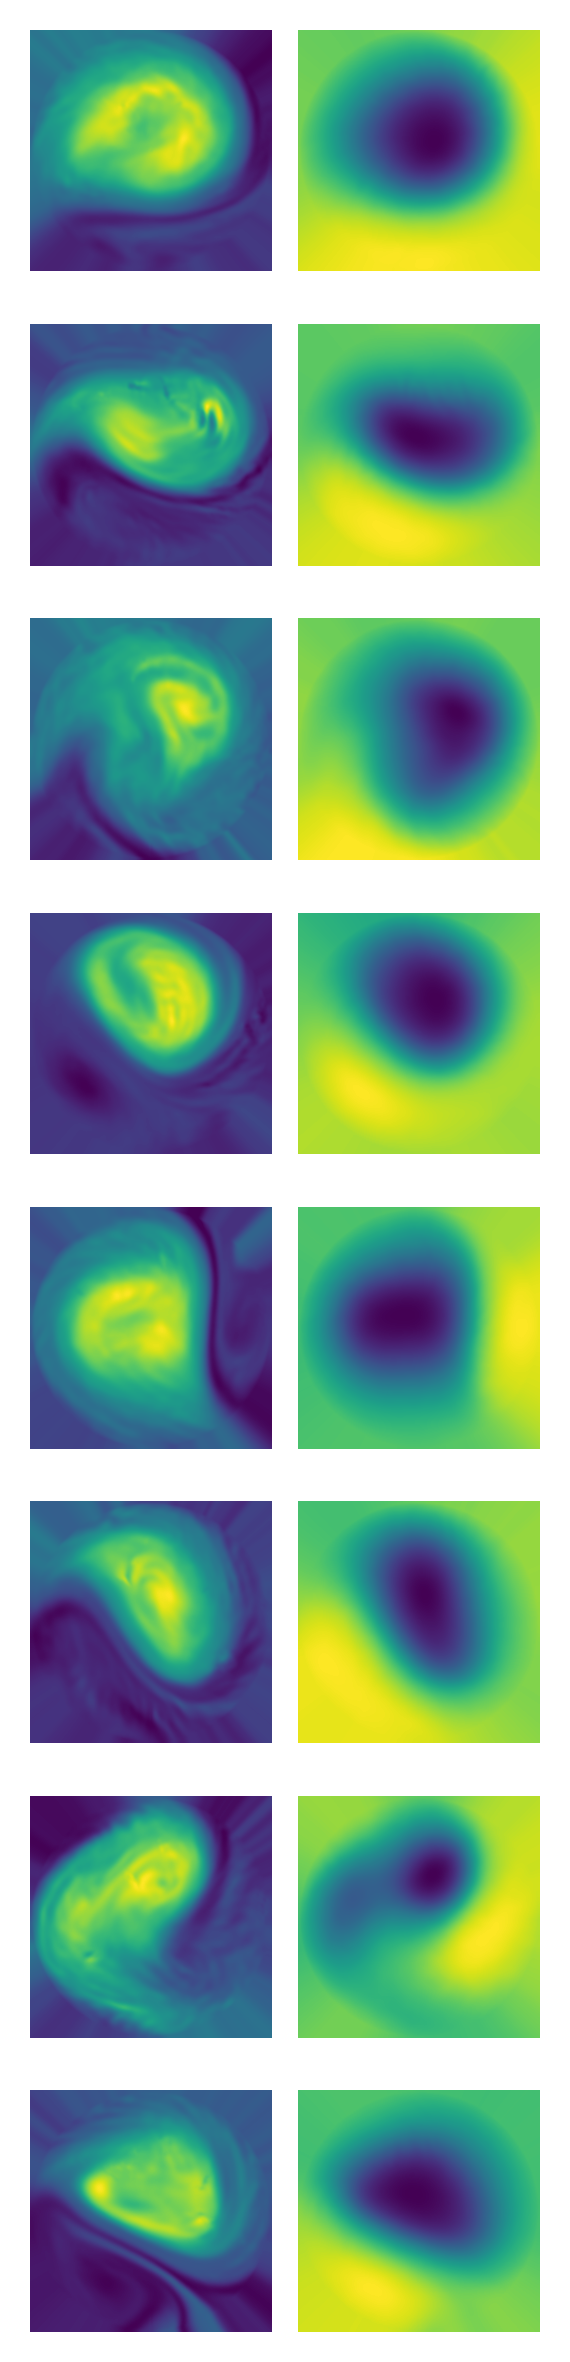

In [8]:
indices = np.random.randint(0, len(train_dataset), size=8)
samples = [train_dataset[idx] for idx in indices]

fig = plt.figure(figsize=(2, 8), dpi=300)
for idx,sample in enumerate(samples):
    sample_np = sample.cpu().numpy()
    p = plt.subplot(8,2,idx*2+1)
    plt.imshow(sample_np[0])#, cmap='gray')
    plt.axis('off')
    p = plt.subplot(8,2,idx*2+2)
    plt.imshow(sample_np[1])#, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
fig.patch.set_facecolor('white')

In [8]:
class unFlatten(nn.Module):
    def __init__(self, channels):
        self.channels = channels
        super().__init__()
        
    def forward(self, x):
        return x.view((x.shape[0], self.channels, int((x.shape[1]/self.channels)**0.5), int((x.shape[1]/self.channels)**0.5)))

def conv2d_size_out(size, kernel_size, stride, padding):
    return (size - kernel_size + 2 * padding) // stride  + 1

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

In [9]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs=128):
        super(Generator, self).__init__()

        self.n_inputs = 128
        self.generator = nn.Sequential(
            nn.Linear(self.n_inputs, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.ReLU(),
            
            unFlatten(1),

            nn.ConvTranspose2d(1, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 2, 4, stride=2, padding=0),
            nn.Sigmoid()
        )


    def forward(self, x_noise):
        x = self.generator(x_noise)
    
        return x

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__() 
        
        ################################
        ###    YOUR CODE HERE        ###
        ################################
        self.conv_dim = (conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out( \
                         256, 3, 2, 1), 3, 1, 0), 3, 2, 1), 3, 1, 0), 3, 2, 1), 3, 1, 0), 3, 2, 1), 3, 1, 0) ** 2) * 64 
        self.discriminator = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.Linear(self.conv_dim, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 64),
            nn.LeakyReLU(),
            
            nn.Linear(64, 1),
        )


    def forward(self, x):
        x_init = x
        x = self.discriminator(x)

        return x

Далее применим описанные классы генератора и дискриминатора для создания WGAN-GP:

In [11]:
latent_dim = 128
mask_torch = torch.unsqueeze(torch.from_numpy(np.load('/content/gdrive/MyDrive/wgan_data/mask_256.npy')), 0).to(DEVICE).float()
mask_torch = torch.unsqueeze(mask_torch, 0)
mask_torch = mask_torch.repeat(1, 2, 1, 1)

In [16]:
gen = Generator(n_inputs=latent_dim)
gen.load_state_dict(torch.load('/content/gen_epoch_29.pth', map_location=torch.device(DEVICE)))
gen = gen.to(DEVICE)

In [16]:
 sum(p.numel() for p in gen.parameters() if p.requires_grad)

840770

In [17]:
dsc = Discriminator()
dsc.load_state_dict(torch.load('/content/dsc_epoch_29.pth', map_location=torch.device(DEVICE)))
dsc = dsc.to(DEVICE)

In [18]:
sum(p.numel() for p in dsc.parameters() if p.requires_grad)

5737953

In [19]:
# Оптимизаторы отдельно для генератора и для дискриминатора
opt_gen = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_dsc = torch.optim.Adam(dsc.parameters(), lr=1e-4, betas=(0.5, 0.9))

Для модели WGAN-GP применяется регуляризация на градиент выхода дискриминатора по его входным данным.

In [40]:
def compute_gradient_penalty(model_dsc, real_samples, fake_samples):
    """
    Calculates the gradient penalty loss for WGAN GP
    model_dsc - дискриминатор
    real_samples - признаковое описание реальных примеров
    fake_samples - признаковое описание примеров, порожденных генератором.
    """
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(DEVICE)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = model_dsc(interpolates)
    fake = Variable(Tensor(d_interpolates.shape[0], 1).fill_(1.0), requires_grad=False).to(DEVICE)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates,
                              inputs=interpolates,
                              grad_outputs=fake,
                              create_graph=True,
                              retain_graph=True,
                              only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    #print(gradient_penalty)
    return gradient_penalty

In [41]:
val_loss_history = []
gen_loss_history = []
dsc_loss_history = []

def train_model(model_gen: torch.nn.Module, 
                model_dsc: torch.nn.Module, 
                train_dataset_full: torch.utils.data.Dataset,
                optimizer_gen: torch.optim.Optimizer,
                optimizer_dsc: torch.optim.Optimizer,
                batch_size = 32,
                max_epochs = 10,
                n_critic = 5,
                lambda_gp = 10):
    
    '''
    Обучение и валидация WGAN-GP.
    
    '''
    train_size = int(0.8 * len(train_dataset_full))
    test_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # lr_scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=5, gamma=0.9) # YOUR CODE HERE
    # lr_scheduler_dsc = torch.optim.lr_scheduler.StepLR(opt_dsc, step_size=5, gamma=0.9) # YOUR CODE HERE
        

    lgen = 0.0
    ldsc = 0.0
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')
        
        model_gen.train()
        model_dsc.train()
        
        with tqdm(total=len(train_loader)) as pbar:
            for idx, real_batch in enumerate(train_loader):

                # шаг оптимизации дискриминатора
                mask_batch = mask_torch.repeat(real_batch.size(0), 1, 1, 1)
                real_batch = real_batch.to(DEVICE)

                opt_dsc.zero_grad()
                #train with real data

                output_dsc_real = model_dsc(real_batch)
                #train with fake data
                fake_input_gen = torch.empty((real_batch.size(0),128)).normal_(mean=0, std=1).to(DEVICE)
                fake_output_gen = model_gen(fake_input_gen).detach() * mask_batch
                
                output_dsc_fake = model_dsc(fake_output_gen)

                #compute gp
                gradient_penalty = compute_gradient_penalty(model_dsc, real_batch, fake_output_gen)
                
                #compute loss
                ldsc = output_dsc_fake.mean() - output_dsc_real.mean() + lambda_gp * gradient_penalty
                dsc_loss_history.append(ldsc.item())
                #print(ldsc)

                ldsc.backward()
                opt_dsc.step()

                if idx % n_critic == 0:
                    
                    # шаг оптимизации генератора
                    opt_dsc.zero_grad()
                    opt_gen.zero_grad()

                    input_gen = torch.empty((real_batch.size(0),128)).normal_(mean=0, std=1).to(DEVICE)
                    output_gen = model_gen(fake_input_gen) * mask_batch
                    
                    output_dsc_g = model_dsc(output_gen)
                    lgen = -output_dsc_g.mean() #was -

                    gen_loss_history.append(lgen.item())

                    lgen.backward()
                    opt_gen.step()

                pbar.update(1)
                
                pbar.set_postfix({'step': idx+1, 'loss_GEN': lgen, 'loss_DSC': ldsc})
                
        torch.save(model_gen.state_dict(), f"gen_epoch_{epoch}.pth")
        torch.save(model_dsc.state_dict(), f"dsc_epoch_{epoch}.pth")

        # Валидация - оценка функции потерь WGAN-GP как D(x_real) - D(x_fake)
        
        model_gen.eval()
        model_dsc.eval()
        val_loss_epoch = 0.0

        with torch.no_grad():
            for idx, real_batch in enumerate(val_loader):
                #print(idx)
                real_batch = real_batch.to(DEVICE)

                output_dsc_real_val = model_dsc(real_batch)
                    
                fake_input_gen = torch.empty((real_batch.size(0),128)).normal_(mean=0, std=1).to(DEVICE)
                fake_output_gen = model_gen(fake_input_gen).detach()

                output_dsc_fake_val = model_dsc(fake_output_gen)

                val_loss_epoch += output_dsc_fake_val.mean() - output_dsc_real_val.mean() #FAKE - REAL как в тренировке, поэтому значение растет на графике
                    
        print("val loss = ", val_loss_epoch.item() / len(val_loader))
        val_loss_history.append(val_loss_epoch.item() / len(val_loader))

        #Draw generator results
        
        # lr_scheduler_gen.step()
        # lr_scheduler_dsc.step()
        
    return val_loss_history, dsc_loss_history, gen_loss_history

In [ ]:
loss_history, dsc_loss_history, gen_loss_history = train_model(gen, dsc,
                                                               train_dataset,
                                                               opt_gen, opt_dsc,
                                                               max_epochs=30,
                                                               n_critic=4,
                                                               lambda_gp=10)

  0%|          | 0/531 [00:00<?, ?it/s]

Starting epoch 1 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -107.41212406015038
Starting epoch 2 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -110.33717105263158
Starting epoch 3 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -149.45548930921052
Starting epoch 4 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -125.93498883928571
Starting epoch 5 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -142.71866188909775
Starting epoch 6 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -87.51243097979324
Starting epoch 7 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -160.1666764567669
Starting epoch 8 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -146.87334057800751
Starting epoch 9 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -139.3134839050752
Starting epoch 11 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -139.65927514097746
Starting epoch 12 of 30


 84%|████████▍ | 447/531 [03:52<00:42,  1.99it/s, step=447, loss_GEN=tensor(972.2266, device='cuda:2', grad_fn=<NegBackward>), loss_DSC=tensor(-289.8235, device='cuda:2', grad_fn=<AddBackward0>)] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -135.03038357612783
Starting epoch 16 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -134.70767739661653
Starting epoch 17 of 30


 99%|█████████▉| 527/531 [04:34<00:02,  2.00it/s, step=526, loss_GEN=tensor(1284.9219, device='cuda:2', grad_fn=<NegBackward>), loss_DSC=tensor(-291.4904, device='cuda:2', grad_fn=<AddBackward0>)]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -135.71438851033835
Starting epoch 21 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -129.0786683505639
Starting epoch 22 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -131.0470512218045
Starting epoch 23 of 30


 23%|██▎       | 120/531 [01:02<03:19,  2.06it/s, step=120, loss_GEN=tensor(1508.5934, device='cuda:2', grad_fn=<NegBackward>), loss_DSC=tensor(-288.1376, device='cuda:2', grad_fn=<AddBackward0>)]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -116.08116482612782
Starting epoch 26 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -127.18500352443608
Starting epoch 27 of 30


  0%|          | 0/531 [00:00<?, ?it/s]

val loss =  -132.21665002349624
Starting epoch 28 of 30


 27%|██▋       | 143/531 [01:14<03:14,  1.99it/s, step=143, loss_GEN=tensor(1419.9557, device='cuda:2', grad_fn=<NegBackward>), loss_DSC=tensor(-288.2043, device='cuda:2', grad_fn=<AddBackward0>)]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 531/531 [04:36<00:00,  1.92it/s, step=531, loss_GEN=tensor(1473.0725, device='cuda:2', grad_fn=<NegBackward>), loss_DSC=tensor(-297.6379, device='cuda:2', grad_fn=<AddBackward0>)]


val loss =  -149.06098742951127


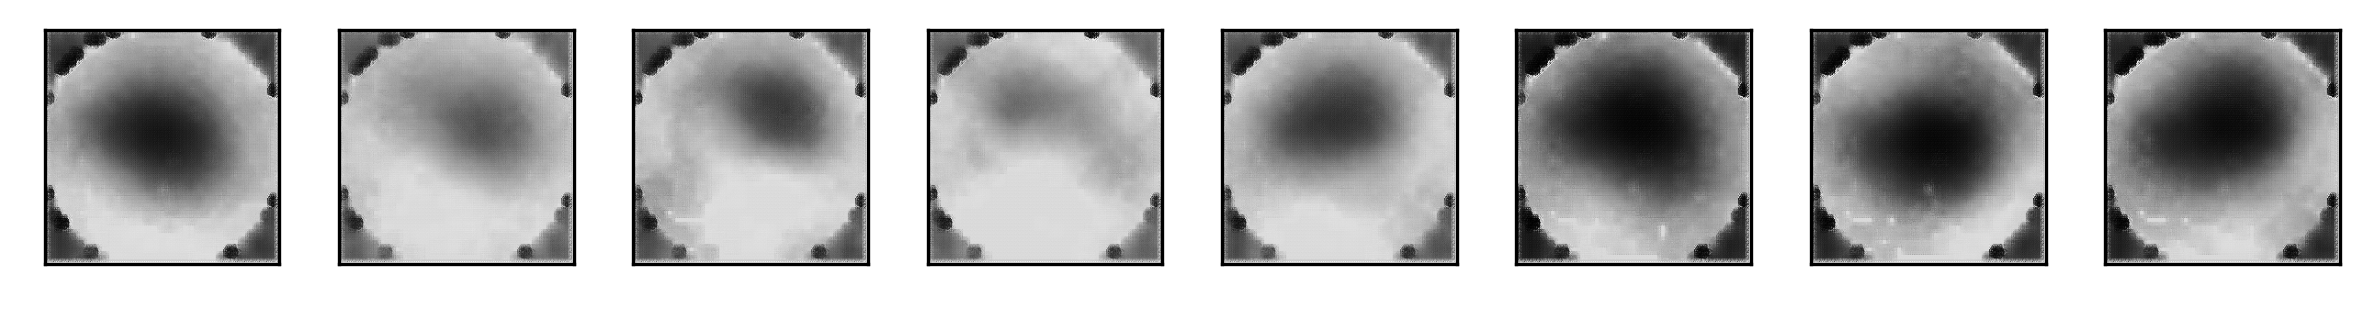

In [ ]:
gen.eval()
dsc.eval()

input_gen = torch.empty((8,128)).normal_(mean=0, std=1).to(DEVICE)
output_gen = gen(input_gen).detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    ax.imshow(output_gen[i][1], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

Для оценки качества обучения, полезно посмотреть на кривые обучения:

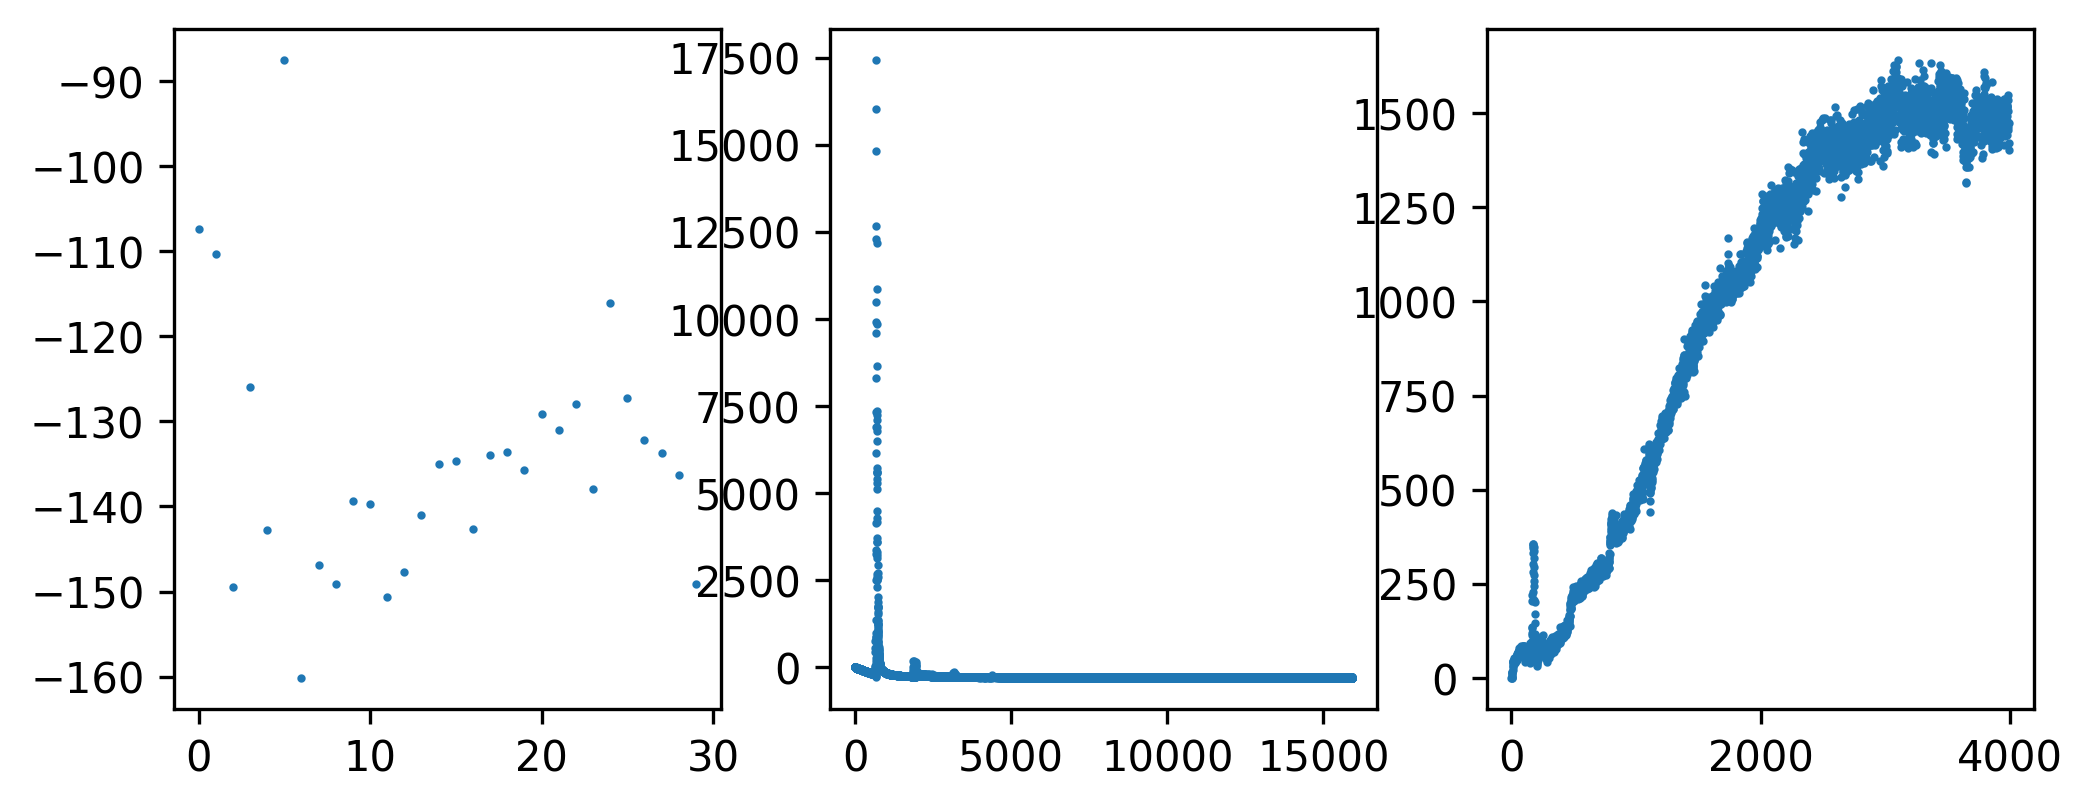

In [ ]:
f = plt.figure(figsize=(8,3), dpi=300)
p = plt.subplot(1,3,1)
_ = plt.scatter(np.arange(len(val_loss_history)), val_loss_history, s=1)

p = plt.subplot(1,3,2)
_ = plt.scatter(np.arange(len(dsc_loss_history)), dsc_loss_history, s=1)

p = plt.subplot(1,3,3)
_ = plt.scatter(np.arange(len(gen_loss_history)), gen_loss_history, s=1)

Далее предлагается применить генератор для порождения новых примеров и оценить их правдоподобность.

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

In [43]:
for idx, real_batch in enumerate(train_loader):
    break

In [45]:
gen = Generator(n_inputs=latent_dim)
gen.load_state_dict(torch.load('/content/gen_epoch_29.pth', map_location=torch.device(DEVICE)))
gen = gen.to(DEVICE)

In [46]:
real_batch = real_batch.to(DEVICE)
mask = mask_torch.repeat(real_batch.size(0), 1, 1, 1)
noise = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), latent_dim)),
                              dtype=torch.float, device=DEVICE))
fake_batch = gen(noise) * mask

In [47]:
real_batch = real_batch.detach().cpu().numpy()
fake_batch = fake_batch.detach().cpu().numpy()

(-0.5, 255.5, 255.5, -0.5)

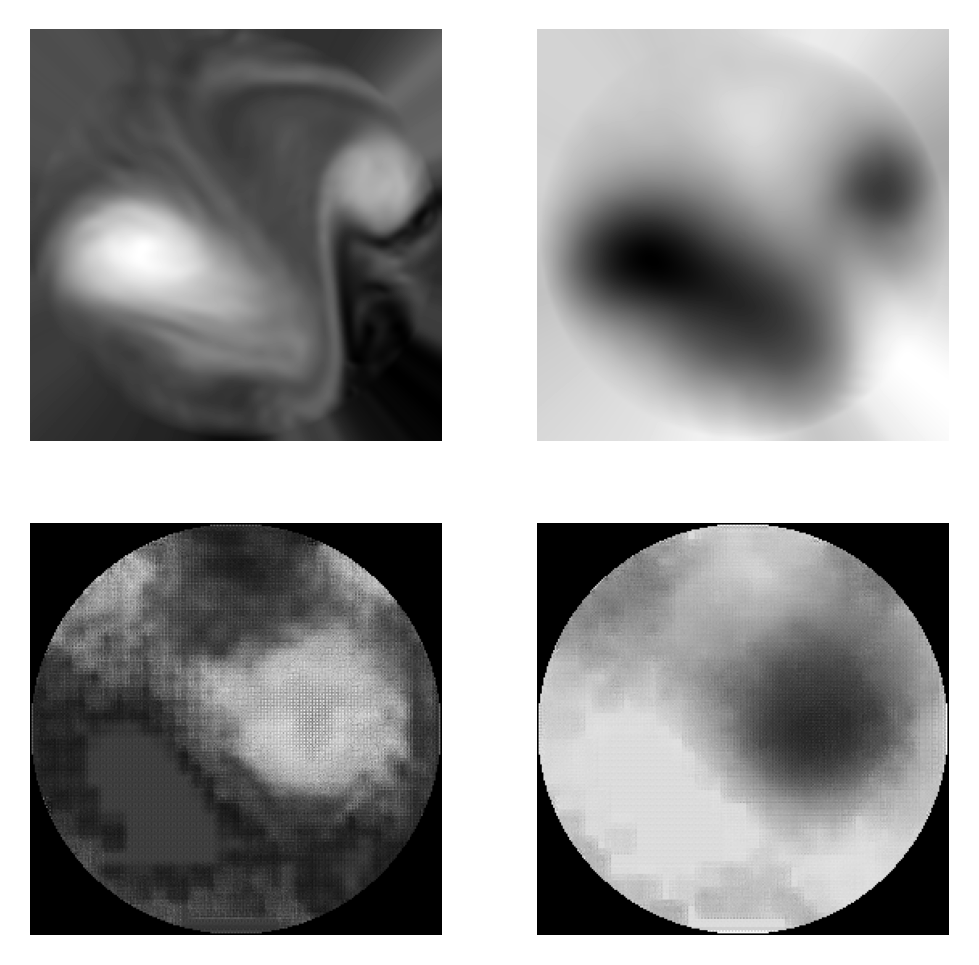

In [48]:
f = plt.figure(figsize=(4,4), dpi=300)
p = plt.subplot(2,2,1)
plt.imshow(real_batch[0,0,...], cmap='gray')
plt.axis('off')
p = plt.subplot(2,2,2)
plt.imshow(real_batch[0,1,...], cmap='gray')
plt.axis('off')

p = plt.subplot(2,2,3)
plt.imshow(fake_batch[2,0,...], cmap='gray')
plt.axis('off')
p = plt.subplot(2,2,4)
plt.imshow(fake_batch[2,1,...], cmap='gray')
plt.axis('off')

In [49]:
indices = np.random.choice(np.arange(32), 16, replace=False)

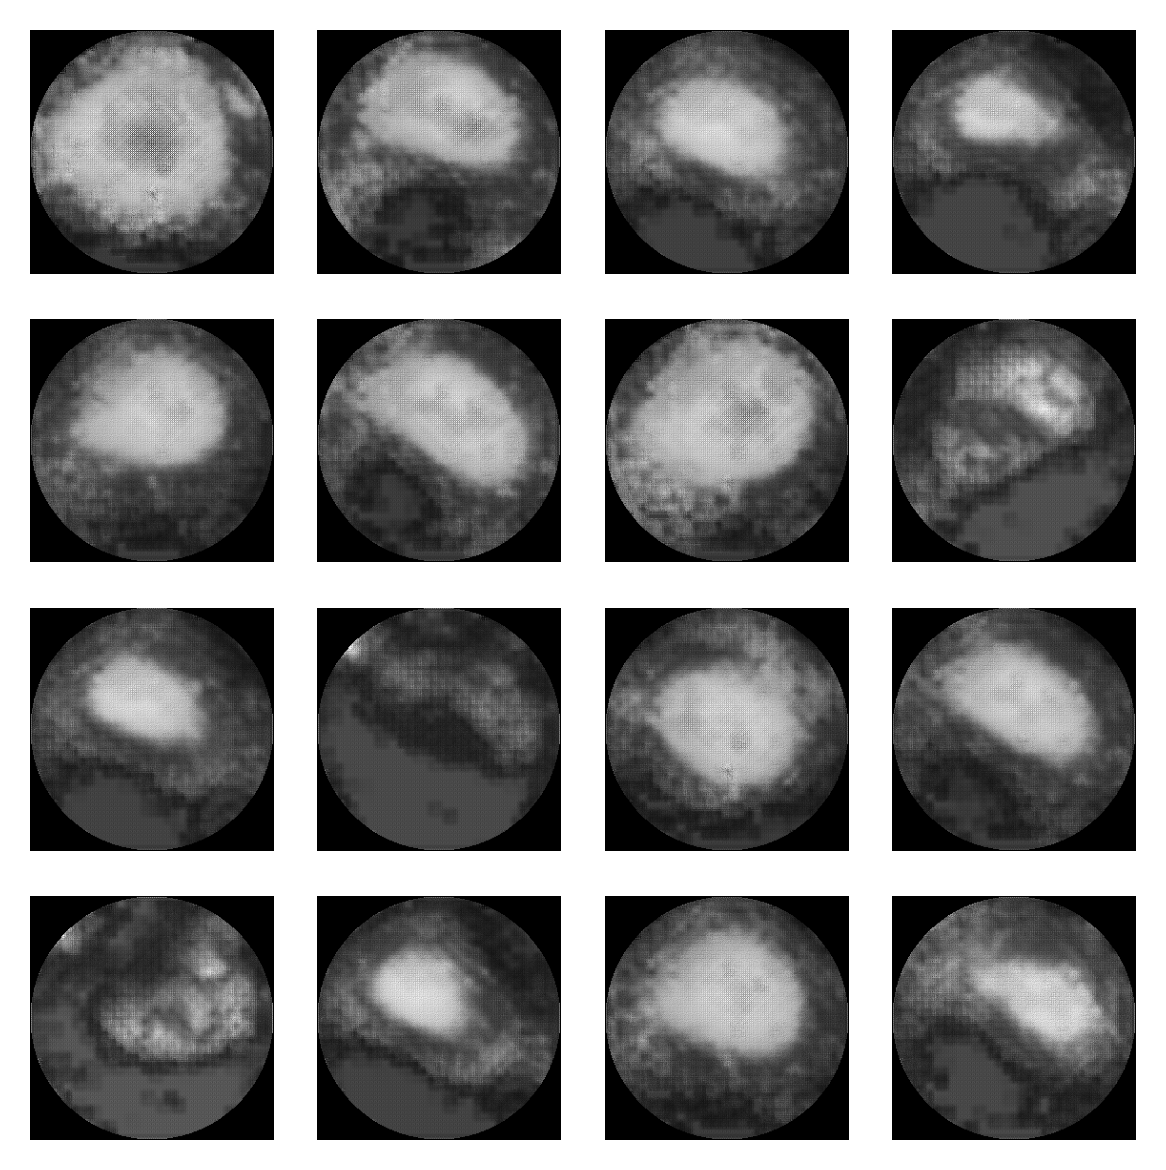

In [50]:
f = plt.figure(figsize=(4,4), dpi=300)

for i,idx in enumerate(indices):
    p = plt.subplot(4,4,i+1)
    plt.imshow(fake_batch[idx,0,...], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

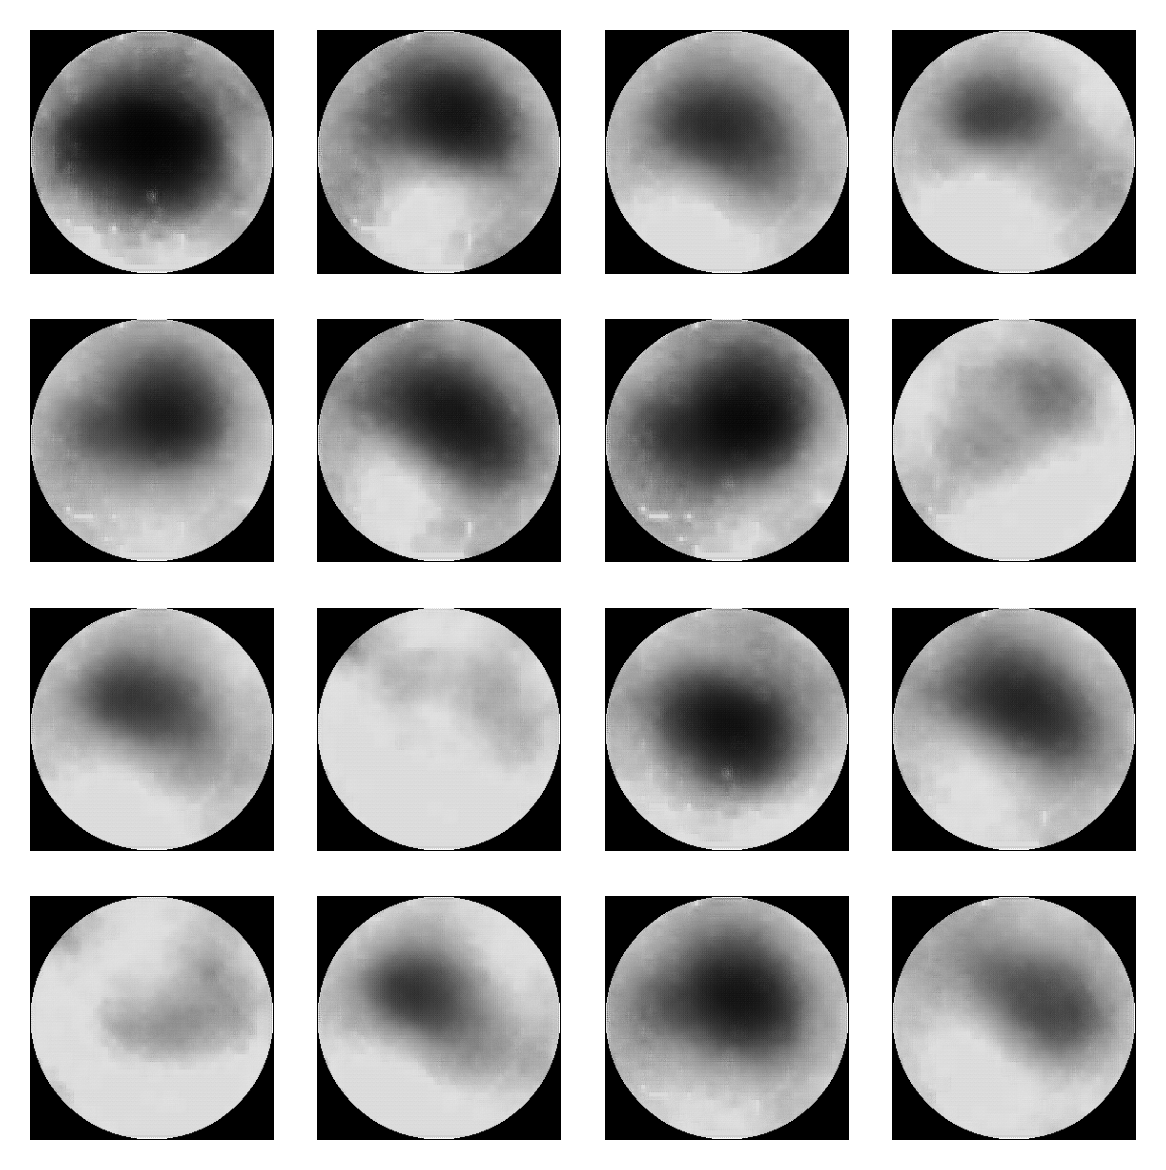

In [51]:
f = plt.figure(figsize=(4,4), dpi=300)

for i,idx in enumerate(indices):
    p = plt.subplot(4,4,i+1)
    plt.imshow(fake_batch[idx,1,...], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

### Использование обученного генератора $\mathcal{G}(\mathbb{\cdot})$

В этой части задания предлагается использовать генератор, обученный в первой части, для порождения примеров, похожих на представленные в обучающей выборке. Напомним, что векторы $z$ порождаются многомерным стандартным нормальным распределением, однако в этом задании следует изменить соотношение обычных экземпляров и экземпляров-аномалий. Этого можно добиться двумя способами:

- Сэмплировать с отклонением (отвержением) примеров. В этом случае векторы $z$ порождаются из стандартного нормального распределения, однако при этом экземпляры с нормой менее перцентиля уровня $98\%$ отклоняются с вероятностью, близкой к $98\%$ (вычислите, какова в точности должна быть вероятность отвержения, если Вы выбрали этот способ сэмплирования). Этот способ гарантирует получение сбалансированной выборки "обычных" и "аномальных" векторов $z$, однако не гарантирует равномерного сэмплирования внутри области "обычных" примеров;
- Сэмплировать равномерно в некоторой области, ограниченной нормой $z$: $z\leq z_{max}$. Здесь тоже должно быть задействовано сэмплирование с отвержением, однако условие отвержения будет другим. Если это ваш выбор, вычислите, каково должно быть $z_{max}$, чтобы выборка обычных и аномальных примеров была сбалансирована. Напомним: известно, что разделение обычных и аномальных примеров в пространстве $\mathbb{Z}$ проходит по значению нормы вектора $|z|_2=q_{0.98}(|z|_2)$. Обратите внимание, что эта величина зависит от размерности $n$ случайной величины $z$, поэтому правильнее писать $q_{0.98}(|z|_2, n)$.

**Подсказка**: поскольку $z$ распределена нормально с единичной матрицей ковариаций $\Sigma$, то каждая из компонент этого вектора распределена нормально с дисперсией $\sigma^2=1$; это означает, что $(|z|_2)^2=\sum_{j=1}^{n}z_j^2$ имеет распределение хи-квадрат, а $|z|_2=\sqrt{\sum_{j=1}^{n}z_j^2}$, соответственно, имеет распределение хи. Для вычисления величины $q_{0.98}(|z|_2, n)$ можно воспользоваться методами распределения, реализованными в библиотеке `scipy`: [`scipy.stats.chi`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi.html). 

После того, как мы знаем, в пределах каких значений $|z|_2$ лежат векторы $z$, отображающиеся в "обычные примеры", нужно научиться сэмплировать их равномерно. Для реализации равномерного сэмплирования в $n$-шаре можно воспользоваться функцией равномерного сэмплирования в многомерном $n$-кубе [numpy.random.rand](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html#numpy.random.rand) с отвержением экземпляров по норме $|z|_2$

После этого следует научиться сэмплировать векторы за пределами этого $n$-шара радиусом $q_{0.98}(|z|_2, n)$. Например, можно сэмплировать равномерно из шара радиусом $R_{outer}=2^{1/n}$ с отвержением всех экземпляров внутри вложенного шара, содержащего "обычные" примеры.

**Подсказка**: можно сразу сэмплировать из шара радиусом $R_{outer}=q_{0.98}(|z|_2, n)*2^{1/n}$ и делить примеры на две категории: обычные (для которых $|z|_2\leq q_{0.98}(|z|_2, n)$) и аномальные (все остальные экземпляры).

### Об эффективном сэмплировании из $n$-мерного шара радиусом $R$

В тот момент, когда требуется порождать векторы, равномерно распределенные в $n$-мерном шаре радиуса $R$, в первую очередь на ум приходит равномерное сэмплирование из $n$-мерного куба со стороной $2R$ с отклонением примеров за пределами шара. Однако с возрастанием количества измерений **$n$** эффективность (скорость) алгоритма такого равномерного сэмплирования резко падает. Вместо этого лучше воспользоваться другим способом:

#### Псевдоалгоритм 1 - равномерного сэмплирования из $n$-мерного шара радиусом $R$
1. Породить $\mathbf{s}\in \mathbb{R}^n$ равномерно на поверхности $n-1$-мерной единичной сферы.
2. Породить $c\sim U[0,1]$ (из равномерного распределения с поддержкой $[0,1]$)
3. Вернуть вектор $\mathbf{b}=s*c^{1/n}*R$

При этом нужно еще уметь равномерно порождать векторы $\mathbf{s}\in \mathbb{R}^n$ на поверхности $n-1$-мерной единичной сферы. Для этого можно воспользоваться следующим алгоритмом:

#### Псевдоалгоритм 2 - равномерного сэмплирования из $n-1$-мерной единичной сферы
1. Породить $n$-мерный вектор, распределенный нормально с диагональной единичной матрицей ковариаций и нулевым вектором средних: $\mathbf{d}\sim\mathcal{N}(\mathbf{0}, \mathbb{I})$.
2. Вычислить $L_2$-норму вектора $\mathbf{d}$:
$$
|\mathbf{d}|_2=\sqrt{\sum_{i=1}^{n}d_i^2}
$$
3. Вернуть вектор-направление единичной длины $\tilde{\mathbf{d}}=\frac{\mathbf{d}}{|\mathbf{d}|_2}$

In [12]:
def SamplingUnitSphereUniform(ndim=2, nsamples=100):
    '''
    Эта функция должна порождать примеры, равномерно распределенные по единичной n-мерной сфере
        (см. псевдоалгоритм 2)
    '''
    d = torch.empty((nsamples, ndim)).normal_(mean=0, std=1) 
    d_norm = torch.norm(d, dim=1)
    d_norm_matrix = d_norm.repeat(ndim, 1).permute(1, 0)
    d = d / d_norm_matrix
    return d

In [13]:
def SamplingBallUniform(ndim=2, radius=1, nsamples=100):
    '''
    Эта функция должна порождать примеры, равномерно распределенные в единичном n-мерном шаре
        (см. псевдоалгоритм 1)
    '''
    s = SamplingUnitSphereUniform(ndim=ndim, nsamples=nsamples)
    c = torch.rand((nsamples, ndim)) ** (1 / ndim)
    b = s * c * radius
    return b

In [14]:
def SampleInnerAndOuterExamples(ndim=2, radius_inner=1, radius_outer=2, nsamples=100):
    '''
    В этой функции следует порождать примеры, равномерно распределенные в ndim-мерном шаре диаметром radius_outer
        и делить их на samples_inner ("обычные") и samples_outer ("аномальные")
        по норме векторов с пороговым значением radius_inner
    '''
    z = SamplingBallUniform(ndim=ndim, radius=radius_outer, nsamples=nsamples)
    z_norm = torch.norm(z, dim=1)
    mask = (z_norm > radius_inner)
    samples_inner = z[~mask]
    samples_outer = z[mask]
    return samples_inner, samples_outer

### Проверка реализации сэмплирования

В качестве проверки можно породить, скажем, 10000 примеров, равномерно распределенных в двумерном шаре (на круге, $n=2$). Внешний радиус нужно поставить в значение $R_{outer}=q_{0.98}(|z|_2, n)*2^{1/n}$, внутренний - в значение $R_{inner}=q_{0.98}(|z|_2, n)$

Ожидаемый результат:
- примеров `examples_inner` и `examples_outer` должно получиться примерно одинаковое количество;
- примеры распределены равномерно по кругу радиусом примерно 4;
- "обычные" (внутри круга радиусом $R_{inner}$) и "аномальные" (в кольце между окружностями радиусом $R_{inner}$ и $R_{outer}$) примеры визуально не перемешиваются;

In [18]:
stats.chi.ppf(0.98, 2)

2.797149622536537

In [19]:
examples_inner, examples_outer = SampleInnerAndOuterExamples(ndim=2,
                                                             radius_inner=stats.chi.ppf(0.98, 2),
                                                             radius_outer=stats.chi.ppf(0.98, 2)*np.sqrt(2),
                                                             nsamples=10000)
examples_inner.shape[0], examples_outer.shape[0]

(4981, 5019)

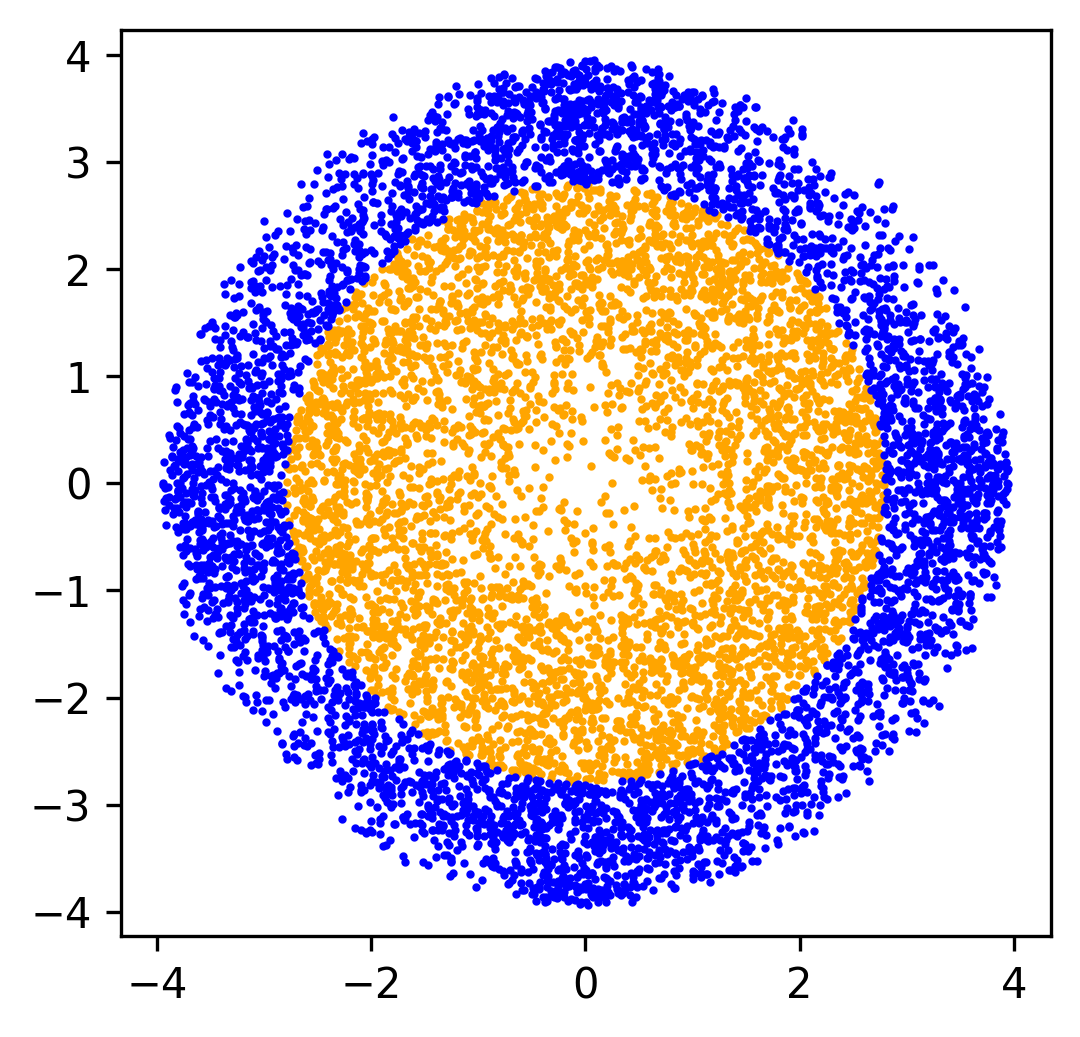

In [20]:
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(examples_inner[:,0], examples_inner[:,1], s=1, color='orange')
plt.scatter(examples_outer[:,0], examples_outer[:,1], s=1, color='blue')
_ = plt.axis('equal')

В качестве второй проверки можно породить, скажем, 10000 примеров, равномерно распределенных в шаре высокой размерности (например, $n=128$). Внешний радиус нужно поставить в значение $R_{outer}=q_{0.98}(|z|_2, n)*2^{1/n}$, внутренний - в значение $R_{inner}=q_{0.98}(|z|_2, n)$

Ожидаемый результат:
- примеров `examples_inner` и `examples_outer` должно получиться примерно одинаковое количество;

In [11]:
latent_dim = 128

In [12]:
chi_p98 = stats.chi.ppf(0.98, latent_dim) #YOUR CODE HERE - значение перцентиля уровня 98% распределения хи с количеством степеней свободы latent_dim
print(chi_p98)

12.7657014145933


In [33]:
examples_inner, examples_outer = SampleInnerAndOuterExamples(ndim=latent_dim,
                                                             radius_inner=chi_p98,
                                                             radius_outer=chi_p98 * (2 ** (1/ latent_dim)),
                                                             nsamples=64)
print(examples_inner.shape[0], examples_outer.shape[0])

63 1


## Обучение классификатора $\mathcal{F}(\mathbf{\cdot})$

In [32]:
# При необходимости можно загрузить нужное состояние генератора
gen = Generator(n_inputs=latent_dim)
gen.load_state_dict(torch.load('/content/gdrive/MyDrive/wgan_data/gen_epoch_29.pth',map_location=torch.device(DEVICE)))
gen = gen.to(DEVICE)
gen.eval()

Generator(
  (generator): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): unFlatten()
    (7): ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): LeakyReLU(negative_slope=0.01)
    (16): ConvTranspose2d(64, 2, kernel_size=(4, 4), stride=(2, 2))
    (17

In [20]:
dsc = Discriminator()
dsc.load_state_dict(torch.load('/content/gdrive/MyDrive/wgan_data/dsc_epoch_29.pth', map_location=torch.device(DEVICE)))
dsc = dsc.to(DEVICE)

In [18]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__() 
        self.conv_dim = (conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out( \
                         256, 3, 2, 1), 3, 1, 0), 3, 2, 1), 3, 1, 0), 3, 2, 1), 3, 1, 0), 3, 2, 1), 3, 1, 0) ** 2) * 64 
        self.classifier = nn.Sequential(
            nn.Conv2d(2, 32, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 64, 3, stride=2, padding=1),
            nn.MaxPool2d(3, stride=1),
            nn.LeakyReLU(),

            nn.Flatten(),

            nn.Linear(self.conv_dim, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 64),
            nn.LeakyReLU(),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x_init = x
        x = self.classifier(x)
        return x

In [22]:
clf = Classifier()
clf = clf.to(DEVICE)

In [28]:
class DS_classifier(Dataset):
    def __init__(self,
                 samples_fname: str = '',
                 labels_fname: str = '',
                 transform: Any = None):

        self.data = np.load(samples_fname, mmap_mode='r')
        self.labels = np.load(labels_fname, mmap_mode='r')
        self.transform = transform

    def __getitem__(self, index):
        sample = self.transform(self.data[index])
        label = self.transform([self.labels[index]])
        return sample, label
    

    def __len__(self):
        return self.labels.shape[0]

In [35]:
#make dataset

gen_inner = None
gen_outer = None
inner_labels = None
outer_labels = None

samples = None
labels = None


for j in range(100):
    z_inner, z_outer = SampleInnerAndOuterExamples(ndim=latent_dim,
                                                   radius_inner=stats.chi.ppf(0.98, latent_dim),
                                                   radius_outer=stats.chi.ppf(0.98, latent_dim) * (2 ** (1 / latent_dim)),
                                                   nsamples=64)
    z_inner = z_inner.to(DEVICE)
    z_outer = z_outer.to(DEVICE)

    mask_in = mask_torch.repeat(z_inner.size(0), 1, 1, 1)
    mask_out = mask_torch.repeat(z_outer.size(0), 1, 1, 1)

    if samples is not None:
        samples = torch.cat((samples,(gen(z_inner) * mask_in).cpu().detach(), (gen(z_outer) * mask_out).cpu().detach()))
        labels = torch.cat((labels, torch.zeros(z_inner.size(0)), torch.ones(z_outer.size(0))))
    else:
        samples = torch.cat(((gen(z_inner) * mask_in).cpu().detach(), (gen(z_outer) * mask_out).cpu().detach()))
        labels = torch.cat((torch.zeros(z_inner.size(0)), torch.ones(z_outer.size(0))))

In [36]:
# samples_np = samples.numpy()
# labels_np = labels.numpy()

In [37]:
# np.save('samples.npy', samples_np)
# np.save('labels.npy', labels_np)

In [35]:
# !cp '/content/samples.npy' '/content/gdrive/MyDrive/wgan_data'

In [29]:
train_dataset_full = DS_classifier('/content/gdrive/MyDrive/wgan_data/samples.npy',
                                   '/content/gdrive/MyDrive/wgan_data/labels.npy',
                                   train_transforms)

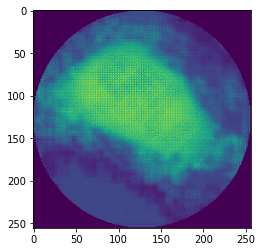

In [82]:
plt.imshow(train_dataset_full[255][0][0]) #-1 191 254 255

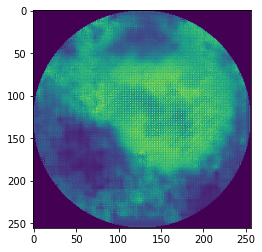

In [78]:
plt.imshow(train_dataset_full[14][0][0])

In [33]:
def train_classifier(model_gen: torch.nn.Module, 
                     model_clf: torch.nn.Module,
                     batch_size = 64,
                     initial_lr = 1e-6,
                     max_epochs = 512,
                     train_dataset_full = train_dataset_full):
    
    val_loss_history = []
    train_loss_history = []

    model_gen.eval()
    loss_function = nn.BCELoss()

    opt = torch.optim.Adam(model_clf.parameters(), lr=initial_lr)
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda = lambda x: x * 1.5) 

    train_size = int(0.8 * len(train_dataset_full))
    test_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, test_size])    

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=int(batch_size/4), shuffle=True, num_workers=2) 
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')

        model_clf.train()

        for objects, labels in train_loader:
            objects = objects.to(DEVICE)
            labels = labels.to(DEVICE)

            opt.zero_grad()
            output = model_clf(objects)


            loss = loss_function(output, labels)
            train_loss_history.append(loss.item())
            loss.backward()

            # if epoch < 12:
            #     opt.step()
            #     lr_scheduler.step()
            # else:
            opt.step()
                
        
        model_clf.eval()
        val_loss_epoch = 0.0
        for objects_v, labels_v in val_loader:
            objects_v = objects_v.to(DEVICE)
            labels_v = labels_v.to(DEVICE)
            output_v = model_clf(objects_v)
            # print(labels_v.shape)
            # print(output_v.shape)
            val_loss_epoch += loss_function(output_v, labels_v) 
            
        val_loss_history.append(val_loss_epoch.item()/len(val_loader))
        print('Eval loss on epoch %d: %f' % (epoch+1, val_loss_epoch.item()/len(val_loader)))
        
        #lr_scheduler.step()
    torch.save(model_clf.state_dict(), f"clf_state.pth")
    return val_loss_history, train_loss_history

In [39]:
val_loss_history, train_loss_history = train_classifier(model_gen=gen,
                                    model_clf=clf,
                                    batch_size = 32,
                                    initial_lr = 1e-4,
                                    max_epochs = 50)

## Применение классификатора $\mathcal{F}(\mathbf{\cdot})$

Применим обученный классификатор для идентификации аномалий в данных.

In [15]:
ds_test = DS('/content/gdrive/MyDrive/wgan_data/pv_data_projected_all.normed01.npy',
             '/content/gdrive/MyDrive/wgan_data/hgt_data_projected_all.normed01.npy',
             '/content/gdrive/MyDrive/wgan_data/mask_256.npy',
             train_transforms)

In [16]:
test_loader = torch.utils.data.DataLoader(ds_test, shuffle=False, batch_size=64)

In [20]:
clf = Classifier()
clf.load_state_dict(torch.load('/content/clf_state.pth'))
clf = clf.to(DEVICE)
clf.eval()

Classifier(
  (classifier): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10816, out_features=512, bias=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Li

In [35]:
output = None
for objects in test_loader:
    objects = objects.to(DEVICE)
    if output is not None:
        output = torch.cat((output, clf(objects).cpu().detach()))
    else:
        output = clf(objects).cpu().detach()

In [36]:
output.shape

torch.Size([21240, 1])

In [37]:
output_np = output.numpy()
#np.save('output.npy', output_np)

In [62]:
!cp '/content/output.npy' '/content/gdrive/MyDrive/wgan_data'

(array([2.000e+00, 4.000e+00, 7.000e+00, 6.000e+00, 2.500e+01, 2.900e+01,
        5.400e+01, 8.700e+01, 1.520e+02, 2.080e+02, 4.060e+02, 6.480e+02,
        9.510e+02, 1.290e+03, 1.623e+03, 1.952e+03, 2.245e+03, 2.210e+03,
        2.162e+03, 1.970e+03, 1.657e+03, 1.232e+03, 9.620e+02, 6.170e+02,
        4.070e+02, 1.850e+02, 9.900e+01, 3.300e+01, 1.000e+01, 7.000e+00]),
 array([0.5207646 , 0.5207788 , 0.520793  , 0.52080727, 0.52082145,
        0.52083564, 0.5208499 , 0.5208641 , 0.5208783 , 0.5208925 ,
        0.52090675, 0.520921  , 0.5209352 , 0.52094936, 0.5209636 ,
        0.52097785, 0.52099204, 0.5210062 , 0.5210205 , 0.5210347 ,
        0.5210489 , 0.5210631 , 0.52107733, 0.5210916 , 0.52110577,
        0.52111995, 0.5211342 , 0.52114844, 0.5211626 , 0.5211768 ,
        0.52119106], dtype=float32),
 <a list of 30 Patch objects>)

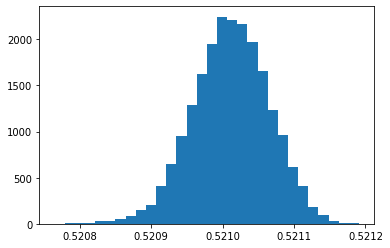

In [38]:
plt.hist(output_np, 30)

## Анализ результатов.

### Классификатор примерно выдает 0.5 в качестве вероятности, и проанализировав картинки, которые генерирует WGAN, я увидела, что в аномальных и обычных примерах встречаются разные картинки, как аномальные, так и нет. К сожалению, в колабе сложно хорошо обучить GAN и возникали трудности при работе с данными, поэтому не удалось достичь хороших результатов((